In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio.v3 as iio
import networkx as nx

from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform

import dissociation as ds

import math
from collections import deque

plt.style.use("./style.mplstyle")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

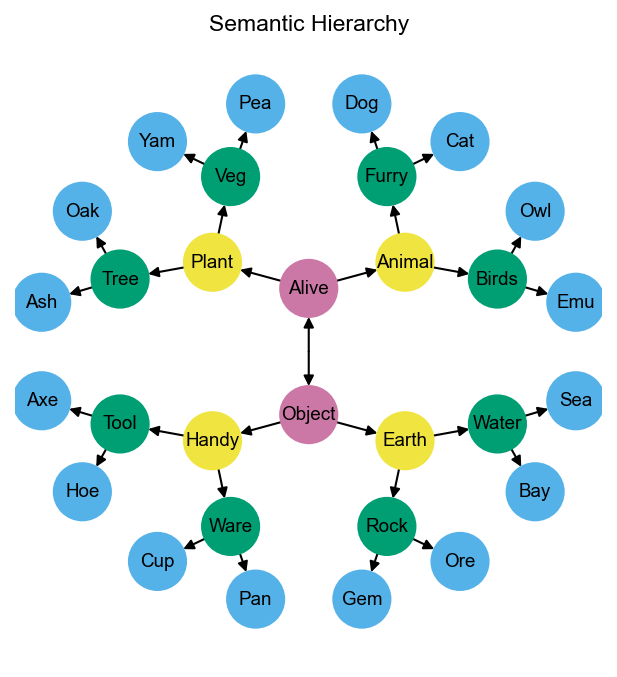

In [2]:
def plot_hierarchy(hierarchy, center=(0, 0), radius_increment=0.1):
    def add_edges_and_positions(node, sub_tree, level, angle_start, angle_end):
        nonlocal pos, edges
        num_nodes = len(sub_tree)
        angle_step = (angle_end - angle_start) / max(1, num_nodes)
        for i, (child, child_tree) in enumerate(sub_tree.items()):
            angle = angle_start + i * angle_step + angle_step / 2
            x = center[0] + (level * radius_increment) * math.cos(angle)
            y = center[1] + (level * radius_increment) * math.sin(angle)
            pos[child] = (x, y)
            edges.append((node, child))
            if isinstance(child_tree, dict):  # If the child has its own subtree
                add_edges_and_positions(
                    child,
                    child_tree,
                    level + 1,
                    angle - angle_step / 2,
                    angle + angle_step / 2,
                )

    # Initialize the graph, positions, and edges
    G = nx.DiGraph()
    pos = {}
    edges = []

    # Assume the root is a single key in the dictionary
    root, root_tree = next(iter(hierarchy.items()))
    pos[root] = center  # Place root at the center
    add_edges_and_positions(root, root_tree, 1, 0, 2 * math.pi)

    # Add edges to the graph
    G.add_edges_from(edges)

    # Plot the graph
    # colors = [(0, 0, 1) for i in range(31)]
    p = dict(nx.single_source_shortest_path_length(G, ""))
    sizes = [0] + [750 for i in range(30)]
    fig, ax = plt.subplots(figsize=(4.0, 4.4))  # plt.figure(figsize=(4, 4))
    nx.draw(
        G,
        pos,
        with_labels=True,
        arrows=True,
        arrowsize=10,
        node_size=sizes,
        node_color=[v + 1 for v in p.values()],
        nodelist=list(p.keys()),
        font_size=9,
        edge_color="k",
        cmap=mcolors.ListedColormap(
            [colors[1], colors[1], colors[3], colors[2], colors[0]]
        ),
    )
    ax.set_title("Semantic Hierarchy")


semantic_hierarchy = {
    "": {
        "Alive": {
            "Animal": {
                "Birds": {"Emu": {}, "Owl": {}},
                "Furry": {"Cat": {}, "Dog": {}},
            },
            "Plant": {"Veg": {"Pea": {}, "Yam": {}}, "Tree": {"Oak": {}, "Ash": {}}},
        },
        "Object": {
            "Handy": {"Tool": {"Axe": {}, "Hoe": {}}, "Ware": {"Cup": {}, "Pan": {}}},
            "Earth": {"Rock": {"Gem": {}, "Ore": {}}, "Water": {"Bay": {}, "Sea": {}}},
        },
    }
}

plot_hierarchy(semantic_hierarchy)
plt.savefig("../results/fig2/semantic-hierarchy.svg", dpi=300)

In [10]:
def breadth_first_collection(tree):
    tree = tree.copy()
    queue = deque(tree.keys())
    result = []

    while queue:
        node = queue.popleft()
        result.append(node)
        children = tree.get(node, {})
        queue.extend(children.keys())
        tree.update(children)

    return result


def collect_leaf_nodes(tree):
    tree = tree.copy()
    queue = deque(tree.keys())
    leaf_nodes = []

    while queue:
        node = queue.popleft()
        children = tree.get(node, {})
        if not children:
            leaf_nodes.append(node)
        queue.extend(children.keys())
        tree.update(children)

    return leaf_nodes


def get_parent_nodes(tree, leaf, path=None):
    tree = tree.copy()
    if path is None:
        path = []

    for key, value in tree.items():
        if leaf in value:
            return path + [key]
        parent_path = get_parent_nodes(value, leaf, path + [key])
        if parent_path:
            return parent_path

    return []


bfs_result = breadth_first_collection(semantic_hierarchy)
leaf_nodes_result = collect_leaf_nodes(semantic_hierarchy)

Y = []
for leaf_node in leaf_nodes_result:
    parent_nodes = get_parent_nodes(semantic_hierarchy, leaf_node) + [leaf_node]
    Y.append([1 if v in parent_nodes else 0 for v in bfs_result])

xs = (
    jax.random.normal(jax.random.key(1), (16, 16)) * 1.0 / np.sqrt(16)
)  # np.identity(16) @ np.diag(jax.random.uniform(jax.random.key(1), 16, minval=0.25, maxval=1.)) # jax.random.orthogonal(jax.random.key(99), 16) # jax.random.normal(jax.random.key(1), (16, 16))
ys = np.asarray(Y).T

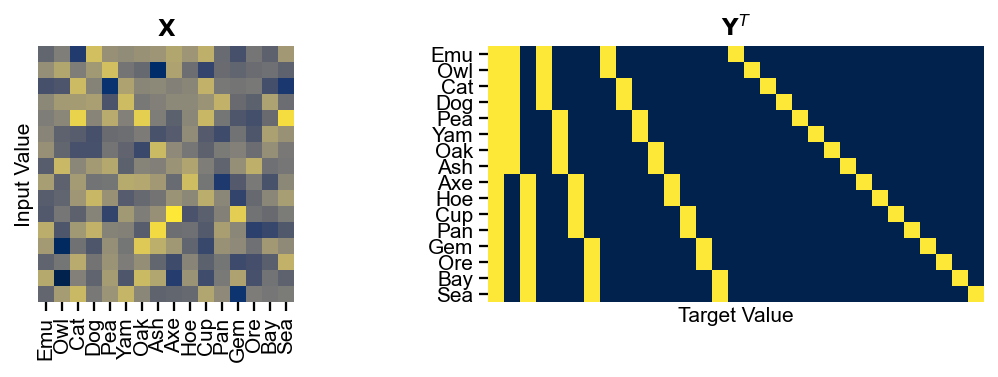

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(2.0 * 3.6, 2.4))
ax = axs[0]
ax.imshow(xs)
ax.set_title("$\\mathbf{X}$")
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_yticks([])
ax.set_ylabel("Input Value")
ax.set_xticks(range(0, 16))
ax.set_xticklabels(leaf_nodes_result, rotation=90)

ax = axs[1]
ax.imshow(ys.T)
ax.set_title("$\\mathbf{Y}^T$")
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xticks([])
ax.set_xlabel("Target Value")
ax.set_yticks(range(0, 16))
ax.set_yticklabels(leaf_nodes_result)

plt.savefig("../results/fig2/inputs-and-targets.svg", dpi=300)

In [37]:
elephant = np.asarray(iio.imread("../data/16x16-elephant.png"))[:, :, 0]
elephant = elephant - np.mean(elephant)
elephant /= np.std(elephant)
elephant /= 4.0

chameleon = np.asarray(iio.imread("../data/16x16-chameleon.png"))[:, :, 0]
chameleon = chameleon - np.mean(chameleon)
chameleon /= np.std(chameleon)

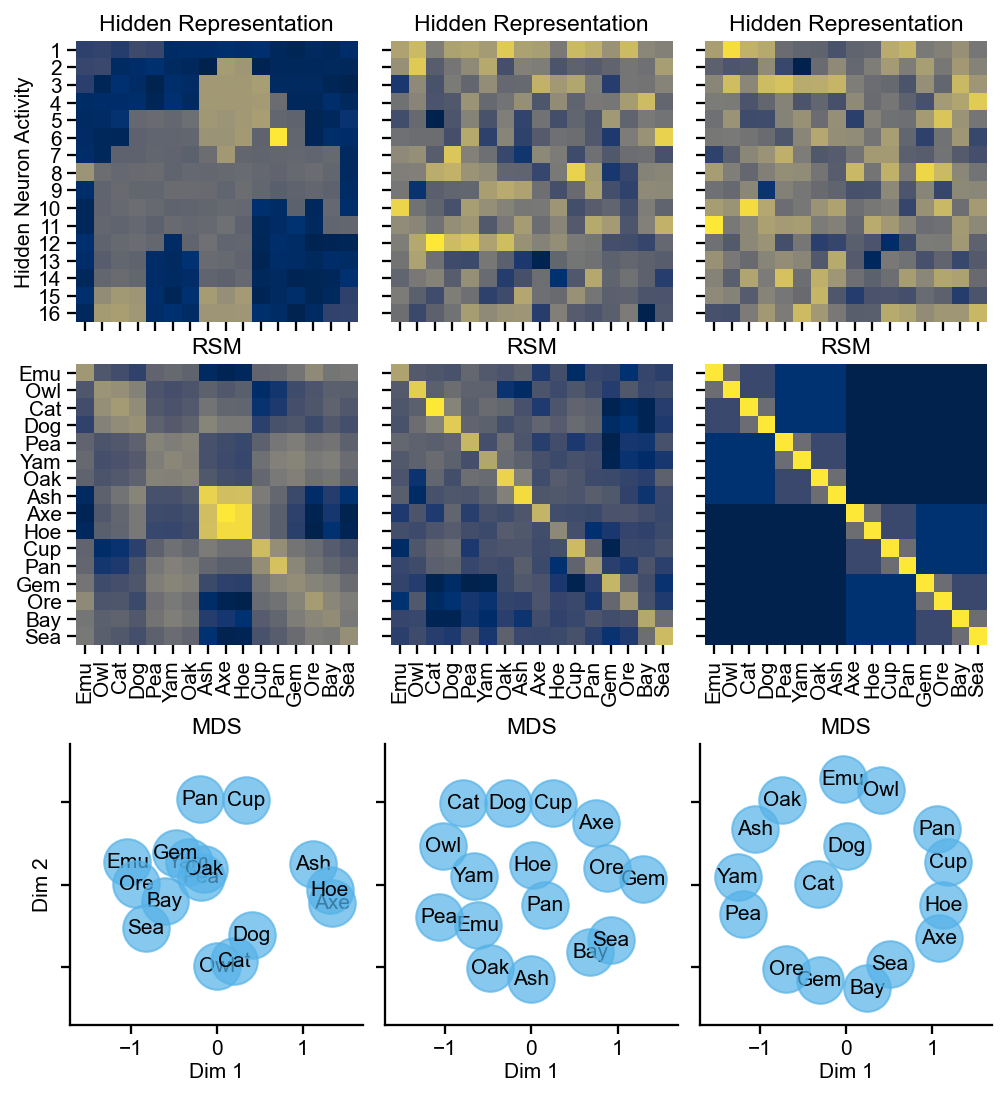

In [39]:
w11 = (
    elephant + jax.random.normal(jax.random.key(1), elephant.shape) * 0.025
) @ np.linalg.pinv(xs)
w21 = ys @ xs.T @ w11.T @ np.linalg.pinv(w11 @ xs @ xs.T @ w11.T)

# w12 = (chameleon + jax.random.normal(jax.random.key(1), chameleon.shape) * .1) @ np.linalg.pinv(xs)
# w22 = ys @ xs.T @ w1.T @ np.linalg.pinv(w1 @ xs @ xs.T @ w1.T)

m, n, o = ds.compact_svd(ys @ xs.T @ np.linalg.pinv(xs).T)
r = jax.random.orthogonal(jax.random.key(1), 16)
w13 = r @ np.sqrt(n) @ o.T @ np.linalg.pinv(xs)
w23 = o @ np.sqrt(n) @ r.T

u, s, v = ds.compact_svd(ys @ xs.T @ np.linalg.pinv(xs @ xs.T))
r = jax.random.orthogonal(jax.random.key(1), 16)
w14 = r @ np.sqrt(s) @ v.T
w24 = u @ np.sqrt(s) @ r.T

ws = [(w11, w21), (w14, w24), (w13, w23)]

fig, axs = plt.subplots(3, 3, figsize=(2.2 * 3, 2.4 * 3))
axs = axs.T.flatten()
for i, (w1, w2) in enumerate(ws):
    ax = axs[(i * 3)]
    ax.imshow(w1 @ xs)
    ax.set_title("Hidden Representation")
    ax.set_xticks(range(16))
    ax.set_xticklabels([])
    ax.set_yticks(range(0, 16))
    if i == 0:
        ax.set_yticklabels(range(1, 17))
        ax.set_ylabel("Hidden Neuron Activity")
    else:
        ax.set_yticklabels([])
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax = axs[(i * 3) + 1]
    ax.imshow(xs.T @ w1.T @ w1 @ xs)
    ax.set_title("RSM")
    ax.set_xticks(range(0, 16))
    ax.set_xticklabels(leaf_nodes_result, rotation=90)
    ax.set_yticks(range(0, 16))
    if i == 0:
        ax.set_yticklabels(leaf_nodes_result)
    else:
        ax.set_yticklabels([])
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax = axs[(i * 3) + 2]
    distances = pdist(jax.device_get(w1 @ xs).T, metric="euclidean")
    distance_matrix = squareform(distances)
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    fit = mds.fit_transform(distance_matrix)
    ax.set_title("MDS")
    for item in range(16):
        ax.scatter(
            fit[item, 0], fit[item, 1], c=colors[0], s=500, zorder=item, alpha=0.7
        )
        ax.text(
            fit[item, 0],
            fit[item, 1],
            leaf_nodes_result[item],
            ha="center",
            va="center",
            zorder=item,
        )
    xlim, ylim = np.max(np.abs(fit), axis=0) * 1.3
    lim = 1.7
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_xticks([-1, 0, 1])
    ax.set_yticklabels([])
    if i == 0:
        ax.set_ylabel("Dim 2")
        ax.set_yticks([-1, 0, 1])
    ax.set_xlabel("Dim 1")

plt.savefig("../results/fig2/h-rsm-mds.svg", dpi=300)

In [68]:
w21.shape

(31, 16)